**Chapter 3 – Classification**

# 1. MNIST

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

DESCR：describing the dataset  
data：an array with one row per instance and one column per feature  
target：containing an array with the labels  

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels

Saving figure some_digit_plot


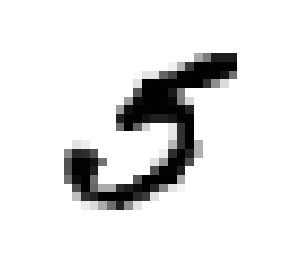

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

we need to shuffle the data

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 2. Binary classifier

distinguishing between just two classes, 5 and not 5

In [13]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

Stochastic Gradient Descent (SGD) classifier  
*【The SGDClassifier relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the random_state parameter.*

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

# 3. Performance Measures
## 3.1 Measuring Accuracy Using Cross-Validation
cross_val_score() function  
K-fold cross- validation means splitting the training set into K-folds

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

accuracy is generally not the preferred performance measure for classifiers  
especially when you are dealing with skewed datasets  
(i.e., when some classes are much more frequent than others).

## 3.2 Confusion Matrix
The general idea is to count the number of times instances of class A are classified as class B.  
**cross_val_predict()**  
performs K-fold cross-validation  
it returns the predictions made on each test fold

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

The first row of this matrix considers non-5 images (the negative class):  
53,272 of them were correctly classified as non-5s (true negatives)  
1,307 were wrongly classified as 5s (false positives).   

The second row considers the images of 5s (the positive class):  
1,077 were wrongly classified as non-5s (false negatives)  
4,344 were correctly classi‐ fied as 5s (true positives).

In [22]:
y_train_perfect_predictions = y_train_5

In [23]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 3.2.1 equations

**Equation 3-1: Precision**

$
\text{precision} = \cfrac{TP}{TP + FP}
$


**Equation 3-2: Recall**

$
\text{recall} = \cfrac{TP}{TP + FN}
$


**Equation 3-3: $F_1$ score**

$
F_1 = \cfrac{2}{\cfrac{1}{\text{precision}} + \cfrac{1}{\text{recall}}} = 2 \times \cfrac{\text{precision}\, \times \, \text{recall}}{\text{precision}\, + \, \text{recall}} = \cfrac{TP}{TP + \cfrac{FN + FP}{2}}
$

![](https://tva1.sinaimg.cn/large/006y8mN6gy1g8r8r5nh9vj30xk0gmjv5.jpg)

### 3.2.2 functions

In [ ]:
# precision and recall

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)

In [ ]:
#f1 score

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

increasing precision reduces recall, and vice versa. This is called the precision/recall tradeoff.

## 3.3 Precision/Recall Tradeoff
![](https://tva1.sinaimg.cn/large/006y8mN6gy1g8r90mpwmej30xk0aygo6.jpg)

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [31]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [32]:
y_some_digit_pred

array([ True])

In [33]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### 3.3.1  how to decide the threshold
For this you will first need to get the scores of all instances in the training set using the cross_val_predict() function again, but this time specifying that you want it to return decision scores instead of predictions:

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [35]:
y_scores.shape

(60000,)

In [36]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [37]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


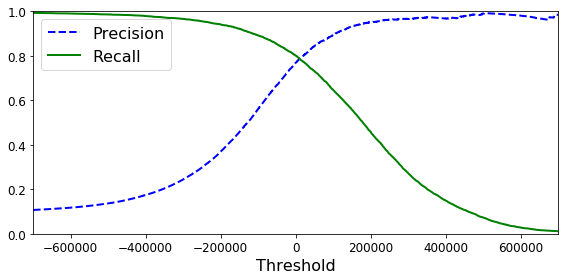

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

*【precision may sometimes go down when you raise the threshold*

In [39]:
(y_train_pred == (y_scores > 0)).all()

True

In [40]:
y_train_pred_90 = (y_scores > 70000)

In [41]:
precision_score(y_train_5, y_train_pred_90)

0.8659205116491548

In [42]:
recall_score(y_train_5, y_train_pred_90)

0.6993174691016417

Saving figure precision_vs_recall_plot


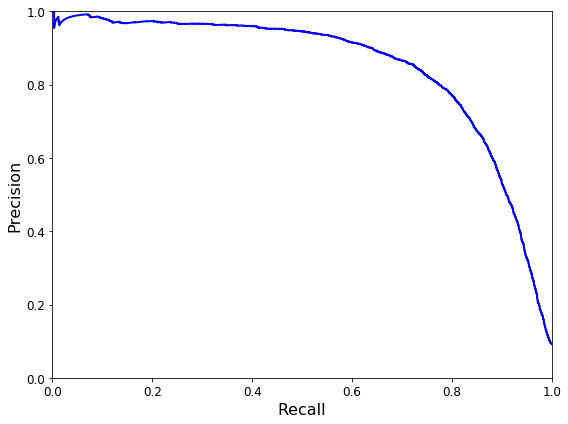

In [43]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

## 3.4 ROC curves
receiver operating characteristic (ROC) curve  
*true positive rate* (another name for recall) against the *false positive rate*  
*FPR* is the ratio of negative instances that are incorrectly classified as positive  
equal to one minus the true negative rate (*TNR*) (*specificity*)

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


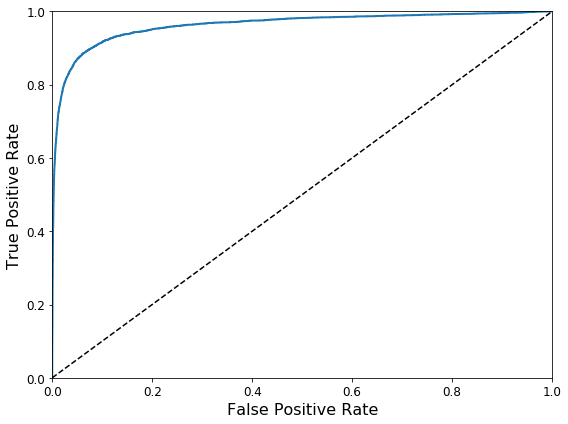

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

the higher the recall (TPR), the more false positives (FPR) the classifier produces  
The dotted line represents the ROC curve of a purely random classifier  
a good classifier stays as far away from that line as possible

### 3.4.1 area under the curve (AUC)

In [46]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624496555967155

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [48]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


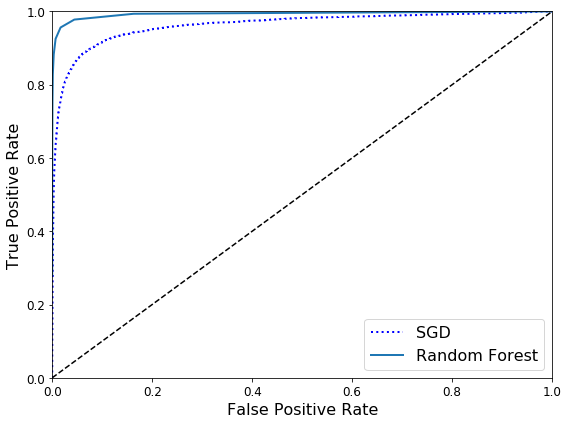

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [51]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [52]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

# 4. Multiclass classification
one-versus-all (OvA) strategy  
one-versus-one (OvO) strategy  
Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐ class classification task, and it automatically runs OvA  
Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

In [53]:
# OvA
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [54]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [55]:
np.argmax(some_digit_scores)

5

In [56]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [57]:
sgd_clf.classes_[5]

5.0

In [58]:
# OvO
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [59]:
len(ovo_clf.estimators_)

45

In [60]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [61]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

It also thinks that the image could instead be a 0 or a 3 (10% chance each).

In [62]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

In [63]:
# scale the inputs to increase accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

# 5.Error Analysis

In [64]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

In [65]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


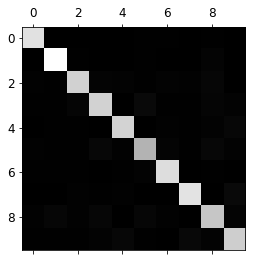

In [66]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [67]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


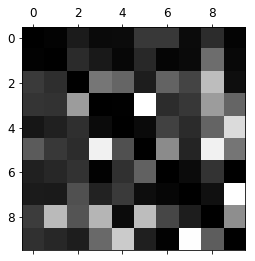

In [68]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

rows represent actual classes, while columns represent predicted classes  
more bright, more images get misclassified  
Analyzing the confusion matrix can often give you insights on ways to improve your classifier. 

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# 6. Multilabel classification

In [70]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [71]:
knn_clf.predict([some_digit])

array([[False,  True]])

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

In [72]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.97709078477525002

sometimes,  not every label is equally important  
give each label a weight equal to its support

# 7. Multioutput classification

In [73]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


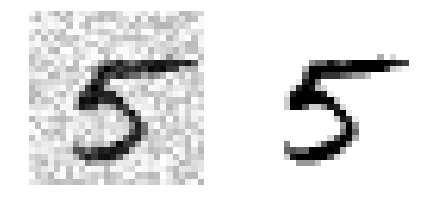

In [74]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


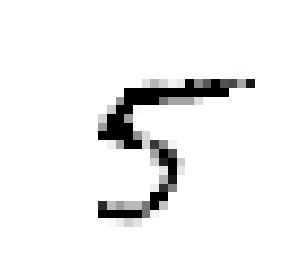

In [75]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

# Extra material

## Dummy (ie. random) classifier

In [76]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

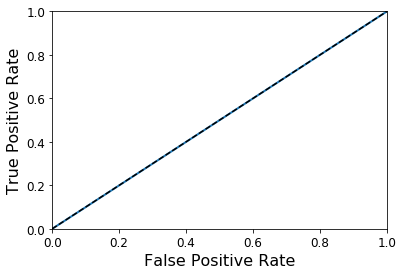

In [77]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [78]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [79]:
y_knn_pred = knn_clf.predict(X_test)

In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

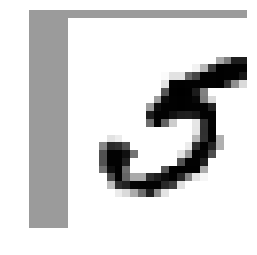

In [81]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [82]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [83]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [84]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [85]:
accuracy_score(y_test, y_knn_expanded_pred)

0.97629999999999995

In [86]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[ 0.       ,  0.       ,  0.5053645,  0.       ,  0.       ,
         0.       ,  0.       ,  0.4946355,  0.       ,  0.       ]])